In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [1]:
import sys
import numpy as np
import os.path as osp
import tensorflow as tf
import glob
import matplotlib.pylab as plt

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf


from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data
from tf_lab.autopredictors.scripts.virt_scan_data import plotting_default_params


from general_tools.notebook.tf import reset_tf_graph                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k, indices_in_iterable


from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [45]:
class_name = raw_input('Give me the class type.\n').lower()
syn_id = shape_net_category_to_synth_id()[class_name]
print syn_id

Give me the class type.
car
02958343


In [46]:
top_eric_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/Point_Clouds/Shape_Net/With_Part_Annotation_Eric_Version/'
segs_top_dir = osp.join(top_eric_dir, syn_id, 'expert_verified', 'points_label')
top_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/nips/v0/part-shape-editing/'

In [47]:
# Builb a map that lists for every model_id in the category
# The types of parts that it includes: (1,2,3) or (1,2,3,4) etc.

erics_seg_extension = '.seg'
model_id_to_part_types = dict()
for file_name in glob.glob(osp.join(segs_top_dir, '*' + erics_seg_extension)):
    gt_seg = np.loadtxt(file_name, dtype=np.int)
    model_name = file_name.split('/')[-1][:-len(erics_seg_extension)]
    gt_seg = np.unique(gt_seg)
    part_types = set(gt_seg) - set([0]) # Zero is not a real segment: remove it.
    model_id_to_part_types[model_name] = tuple(part_types)

In [48]:
from collections import defaultdict
part_types_to_models = defaultdict(list)

for model, part_type in model_id_to_part_types.iteritems():
    part_types_to_models[part_type].append(model)
    
for part_type in part_types_to_models:
    print part_type, len(part_types_to_models[part_type])

(1, 2, 3, 4) 1529
(1, 2, 4) 3
(1, 3, 4) 79
(2, 3, 4) 203
(3, 4) 9
(2, 4) 1


In [49]:
# For editing use!

# Chair: Add arm-rest
# Car: Make it convertible
# Mug: Remove handle
# Airplane: adding/removing engine is too hard to see: mostly see style change - making it more fighter like.
interesting_part_types = {'chair': ((1, 2, 3, 4), (1, 2, 3)),
                          'car': ((2, 3, 4), (1, 2, 3, 4)),
                          'mug': ((2,), (1, 2)),
                          'airplane': ((1, 2, 3, 4), (1, 2, 3))
                         }

In [50]:
experiment_name = '1_three_fc_dec_with_spn_2048pts_chamfer'
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
train_dir = osp.join(top_data_dir, 'OUT/models/nips/vanilla_ae/')
train_dir = osp.join(train_dir, experiment_name)
conf = Conf.load(osp.join(train_dir, 'configuration'))
conf.n_output = conf.n_input
reset_tf_graph()
ae = PointNetAutoEncoder(experiment_name, conf)
saved_epochs = read_saved_epochs(conf.train_dir)
last_epoch = saved_epochs[-1]
ae.restore_model(conf.train_dir, last_epoch, verbose=True)

Model restored in epoch 1000.


In [51]:
n_pc_samples = 2048
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'

full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
full_pclouds_path = osp.join(full_pclouds_path, syn_id)
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')
full_pclouds, full_model_ids, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,\
                                                                           n_threads=50, loader=sn_pc_loader)

print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

7497 files containing complete point clouds were found.


In [52]:
_, latent_codes, _ = latent_embedding_of_entire_dataset(PointCloudDataSet(full_pclouds, labels=full_model_ids, init_shuffle=False), ae, conf)

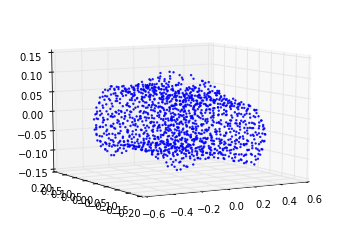

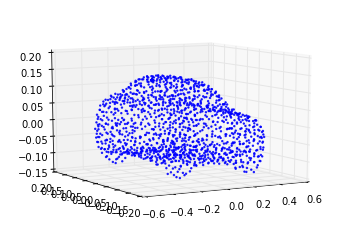

In [53]:
cat1 = interesting_part_types[class_name][0]
cat1 = part_types_to_models[cat1]
cat1_index = indices_in_iterable(full_model_ids, cat1)
cat1_index

cat1_mv = np.mean(latent_codes[cat1_index,:], axis=0)    # Mean vector

cat2 = interesting_part_types[class_name][1]
cat2 = part_types_to_models[cat2]
cat2_index = indices_in_iterable(full_model_ids, cat2)
cat2_mv = np.mean(latent_codes[cat2_index,:], axis=0)    # Mean vector

Point_Cloud(ae.decode(cat1_mv)[0]).plot();
Point_Cloud(ae.decode(cat2_mv)[0]).plot();

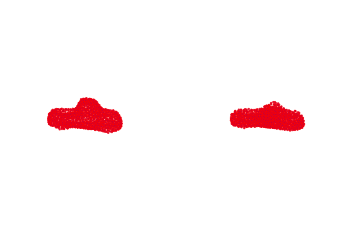

In [82]:
# plt.ioff()

i = 18

if class_name == 'mug':
    plotconf = {}
    plotconf['azim'] = 80
    plotconf['in_u_sphere'] = True
    plotconf['s'] = 4
else:    
    plotconf = plotting_default_params(class_name)


plotconf['elev'] = 10
plotconf['show_axis'] = False
plotconf['show'] = False

plotconf['azim'] = -80
plotconf['in_u_sphere'] = True


fig = plt.figure()
ax = plt.subplot(1, 2, 1, projection='3d')
pc = Point_Cloud(ae.decode(latent_codes[cat2_index[i]])[0])
pc.save_as_ply('test')
pc.plot(axis=ax, **plotconf)

ax = plt.subplot(1, 2, 2, projection='3d')
pc = Point_Cloud(ae.decode(latent_codes[cat2_index[i]] + (cat1_mv - cat2_mv) )[0])
pc.plot(axis=ax, **plotconf);

# fig.savefig(osp.join(top_out_dir))

# plt.close()




In [219]:
# max-min coordinate variation among the two clusters.

a1 = np.mean(np.min(np.min(full_pclouds[cat1_index], axis=1), axis=1))
b1 = np.mean(np.max(np.max(full_pclouds[cat1_index], axis=1), axis=1))
t1 = abs(a1)+abs(b1)

a2 = np.mean(np.min(np.min(full_pclouds[cat2_index], axis=1), axis=1))
b2 = np.mean(np.max(np.max(full_pclouds[cat2_index], axis=1), axis=1))
t2 = abs(a2)+abs(b2)

print abs(t2-t1)/max(t1, t2)

0.0302126
